##Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/neuro140fp"
!ls
# !unrar x 'Amharic Character Dataset 1.rar'


Mounted at /content/drive
/content/drive/My Drive/neuro140fp
 am_dataset  'Amharic Character Dataset 1.rar'	 ethiopic.ipynb   models_path   supported_chars.csv


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

class Ethiopic(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.image_filenames = os.listdir(data_dir)
        self.transform = transform
        self.char_to_id_mapping = self._create_char_to_id_mapping(csv_path)

    def _create_char_to_id_mapping(self, csv_path):
        df = pd.read_csv(csv_path)
        char_to_id_mapping = {char: i for i, char in enumerate(df['Character'].unique())}
        return char_to_id_mapping

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        image = Image.open(os.path.join(self.data_dir, filename))
        if self.transform:
          image = self.transform(image)

        file_id = int(filename.split('.')[0][:3])
        label_part = filename.split('.')[0][3:]

        label = file_id - 1

        return image, label

    def __len__(self):
        return len(self.image_filenames)



##Verifying Image and label mapping
here I randomly selected 10 images and labels from the dataset to verify for accurate mapping.

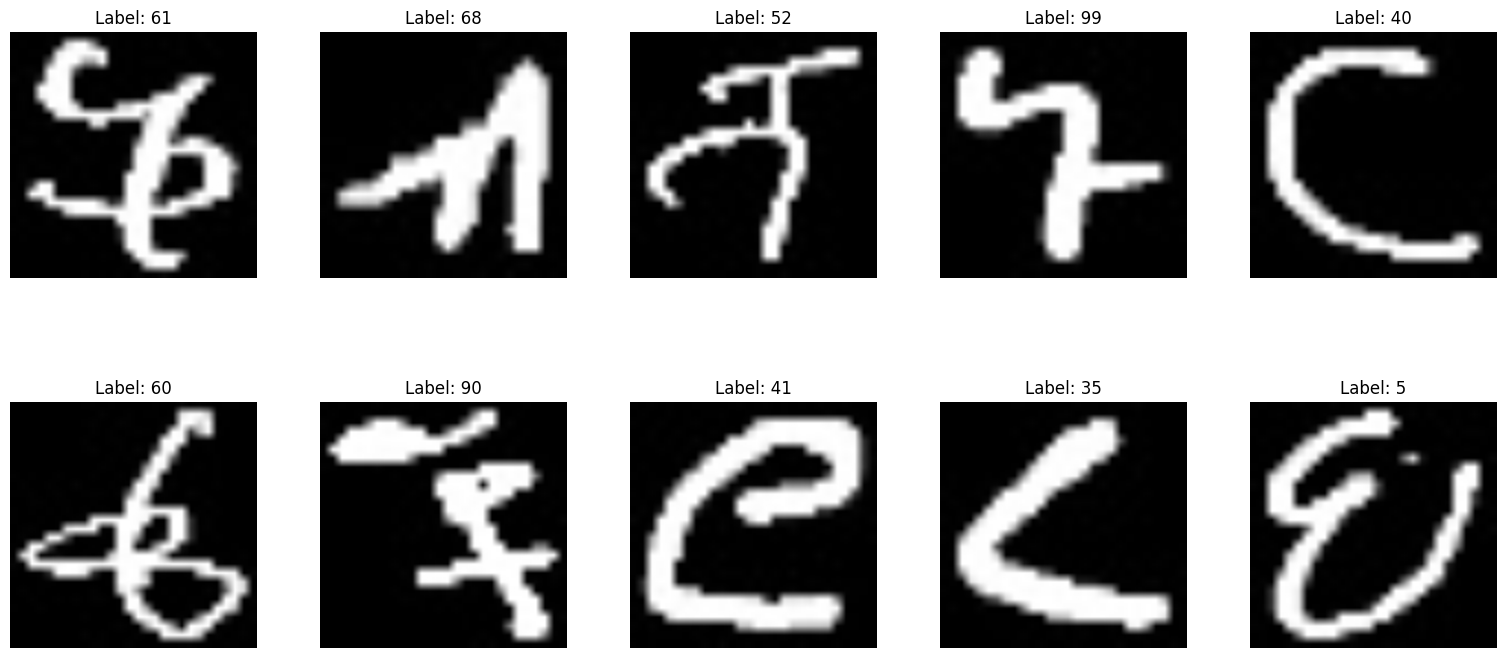

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

dataset = Ethiopic(data_dir ="/content/drive/My Drive/neuro140fp/am_dataset",csv_path = "/content/drive/My Drive/neuro140fp/supported_chars.csv", transform = train_transform)
indices = random.sample(range(len(dataset)), 10)

# Set up the plot
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i, idx in enumerate(indices):
    image, label = dataset[idx]

    image_np = image.numpy().transpose((1, 2, 0))
    if image_np.shape[2] == 1:
        image_np = np.squeeze(image_np, axis=2)
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.show()

##Do train and test split

In [ ]:
from torch.utils.data import DataLoader, random_split
total_size = len(dataset)
# doing a 80/20 random split
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

##Train and validate

In [ ]:
torch.cuda.empty_cache()

import torch
import pandas as pd
from torchvision import models
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from fastprogress import progress_bar

model_dict = {
    # 'AlexNet': models.alexnet(),
    # 'ResNet': models.resnet18(),
    'DenseNet': models.densenet121(),
    'VGG_net': models.vgg16_bn(),
}

results = {
    'model_name': [],
    'epoch': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# iterating through the model dict to load all models
for model_name, model in model_dict.items():
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
# training over 20 epochs
    for epoch in range(20):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_accum = 0

        for inputs, labels in progress_bar(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_accum += loss.item() * inputs.size(0)  # Aggregate the loss
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_loss = train_loss_accum / train_total
        # validation :)
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_accum = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss_accum += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss = val_loss_accum / val_total

        print(f'Epoch {epoch} - Model: {model_name} Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save results
        results['model_name'].append(model_name)
        results['epoch'].append(epoch)
        results['train_accuracy'].append(train_accuracy)
        results['val_accuracy'].append(val_accuracy)
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        models_folder = "models_path"

        if not os.path.exists(models_folder):
          os.makedirs(models_folder)

        torch.save(model.state_dict(), os.path.join(models_folder, f'{model_name}_epoch_{epoch}.pth'))

# Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{model_name}_training_results.csv', index=False)





cuda


Epoch 0 - Model: DenseNet Train Acc: 0.5432, Val Acc: 0.8016, Train Loss: 1.8601, Val Loss: 0.6839


Epoch 1 - Model: DenseNet Train Acc: 0.8538, Val Acc: 0.8477, Train Loss: 0.4920, Val Loss: 0.4903


Epoch 2 - Model: DenseNet Train Acc: 0.8885, Val Acc: 0.9029, Train Loss: 0.3633, Val Loss: 0.3042


Epoch 3 - Model: DenseNet Train Acc: 0.8997, Val Acc: 0.8771, Train Loss: 0.3155, Val Loss: 0.4288


Epoch 4 - Model: DenseNet Train Acc: 0.9142, Val Acc: 0.8987, Train Loss: 0.2644, Val Loss: 0.3408


Epoch 5 - Model: DenseNet Train Acc: 0.9237, Val Acc: 0.8861, Train Loss: 0.2419, Val Loss: 0.3417


Epoch 6 - Model: DenseNet Train Acc: 0.9284, Val Acc: 0.9104, Train Loss: 0.2154, Val Loss: 0.2861


Epoch 7 - Model: DenseNet Train Acc: 0.9321, Val Acc: 0.9184, Train Loss: 0.2051, Val Loss: 0.2739


Epoch 8 - Model: DenseNet Train Acc: 0.9365, Val Acc: 0.9259, Train Loss: 0.1876, Val Loss: 0.2257


Epoch 9 - Model: DenseNet Train Acc: 0.9404, Val Acc: 0.9093, Train Loss: 0.1755, Val Loss: 0.2975


Epoch 10 - Model: DenseNet Train Acc: 0.9481, Val Acc: 0.9288, Train Loss: 0.1493, Val Loss: 0.2287


Epoch 11 - Model: DenseNet Train Acc: 0.9449, Val Acc: 0.9085, Train Loss: 0.1547, Val Loss: 0.3087


Epoch 12 - Model: DenseNet Train Acc: 0.9505, Val Acc: 0.9229, Train Loss: 0.1422, Val Loss: 0.2523


Epoch 13 - Model: DenseNet Train Acc: 0.9526, Val Acc: 0.9317, Train Loss: 0.1367, Val Loss: 0.2151


Epoch 14 - Model: DenseNet Train Acc: 0.9601, Val Acc: 0.9208, Train Loss: 0.1169, Val Loss: 0.2585


Epoch 15 - Model: DenseNet Train Acc: 0.9586, Val Acc: 0.9381, Train Loss: 0.1162, Val Loss: 0.2222


Epoch 16 - Model: DenseNet Train Acc: 0.9625, Val Acc: 0.9112, Train Loss: 0.1058, Val Loss: 0.3330


Epoch 17 - Model: DenseNet Train Acc: 0.9664, Val Acc: 0.9288, Train Loss: 0.0977, Val Loss: 0.2322


Epoch 18 - Model: DenseNet Train Acc: 0.9611, Val Acc: 0.9349, Train Loss: 0.1095, Val Loss: 0.2282


Epoch 19 - Model: DenseNet Train Acc: 0.9632, Val Acc: 0.9427, Train Loss: 0.0991, Val Loss: 0.2144


Epoch 0 - Model: VGG_net Train Acc: 0.0409, Val Acc: 0.0845, Train Loss: 5.0734, Val Loss: 3.8170


Epoch 1 - Model: VGG_net Train Acc: 0.0530, Val Acc: 0.1552, Train Loss: 4.0754, Val Loss: 3.5310


Epoch 2 - Model: VGG_net Train Acc: 0.0722, Val Acc: 0.1907, Train Loss: 3.7911, Val Loss: 3.1781


Epoch 3 - Model: VGG_net Train Acc: 0.0973, Val Acc: 0.2048, Train Loss: 3.5419, Val Loss: 2.9881


Epoch 4 - Model: VGG_net Train Acc: 0.1748, Val Acc: 0.3733, Train Loss: 3.0410, Val Loss: 2.1907


Epoch 5 - Model: VGG_net Train Acc: 0.4351, Val Acc: 0.7149, Train Loss: 1.9279, Val Loss: 0.8947


Epoch 6 - Model: VGG_net Train Acc: 0.6513, Val Acc: 0.8352, Train Loss: 1.1632, Val Loss: 0.5585


Epoch 7 - Model: VGG_net Train Acc: 0.7497, Val Acc: 0.8771, Train Loss: 0.8276, Val Loss: 0.3878


Epoch 8 - Model: VGG_net Train Acc: 0.8039, Val Acc: 0.8744, Train Loss: 0.6404, Val Loss: 0.3983


Epoch 9 - Model: VGG_net Train Acc: 0.8393, Val Acc: 0.8971, Train Loss: 0.5334, Val Loss: 0.3182


Epoch 10 - Model: VGG_net Train Acc: 0.8562, Val Acc: 0.8835, Train Loss: 0.4679, Val Loss: 0.3700


Epoch 11 - Model: VGG_net Train Acc: 0.8777, Val Acc: 0.9043, Train Loss: 0.4032, Val Loss: 0.3029


Epoch 12 - Model: VGG_net Train Acc: 0.8817, Val Acc: 0.9011, Train Loss: 0.3782, Val Loss: 0.3097


Epoch 13 - Model: VGG_net Train Acc: 0.8950, Val Acc: 0.9171, Train Loss: 0.3290, Val Loss: 0.2580


Epoch 14 - Model: VGG_net Train Acc: 0.9038, Val Acc: 0.9181, Train Loss: 0.3120, Val Loss: 0.2809


Epoch 15 - Model: VGG_net Train Acc: 0.9079, Val Acc: 0.9237, Train Loss: 0.2847, Val Loss: 0.2572


Epoch 16 - Model: VGG_net Train Acc: 0.9155, Val Acc: 0.9205, Train Loss: 0.2573, Val Loss: 0.2722


Epoch 17 - Model: VGG_net Train Acc: 0.9238, Val Acc: 0.9245, Train Loss: 0.2479, Val Loss: 0.2513


Epoch 18 - Model: VGG_net Train Acc: 0.9313, Val Acc: 0.9093, Train Loss: 0.2174, Val Loss: 0.3320


Epoch 19 - Model: VGG_net Train Acc: 0.9321, Val Acc: 0.9272, Train Loss: 0.2104, Val Loss: 0.2546
